###FILTERING OUT GOOD HANDWRITING SAMPLES TO BE CONSIDERED AS BENCHMARK FOR ACCURACY JUDGEMENT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pathlib, os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
labels1 = ['AA', 'ADA', 'AN', 'BA', 'BHA', 'BI', 'C', 'CH', 'CN', 'DA', 'DDA',]
labels2 = ['DDH', 'DHA', 'DRA', 'E', 'EN', 'G', 'GH', 'HA', 'I', 'II', 'JA', 'JH', 'K']
labels3 = ['KH', 'KT', 'LA', 'MA', 'MN', 'MSA', 'NA', 'O', 'OI', 'OU', 'PA','PHA']
labels4 = ['RA', 'RI', 'S', 'SA', 'T', 'TA', 'THA', 'TTA', 'U', 'UN', 'UU', 'Y', 'YA']

labels = labels1+labels2+labels3+labels4

In [ ]:
src_path = ['/content/drive/MyDrive/sih/90point/'+x for x in labels4]
dest_path = ['/content/drive/MyDrive/sih/stuff/'+x for x in labels4]

In [4]:
def saveplot(path, x, y):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot()
    ax.scatter(x, y, c='green', s=20)
    ax.set_xlim(0, 512)
    ax.set_ylim(0, 512)
    ax.set_axis_off()
    plt.savefig(path, bbox_inches='tight')
    plt.close()

In [5]:
def showplot(x, y):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot()
    ax.scatter(x, y, c='green', s=20)
    ax.set_xlim(-50, 550)
    ax.set_ylim(-50, 550)
    ax.set_axis_off()
    #plt.savefig(path, bbox_inches='tight')
    plt.show()
    plt.close()

**USING 'A' AS THE SAMPLE, SUPERIMPOSED IMAGES OF ALL 'A'**

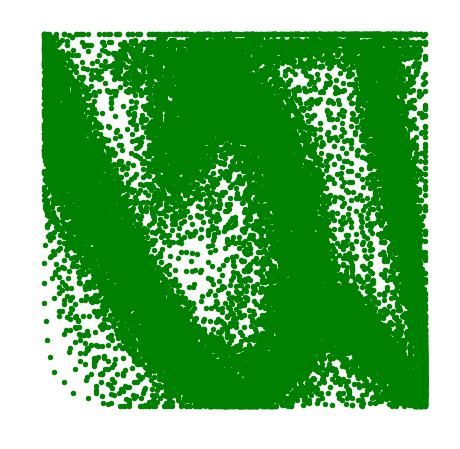

In [6]:
# superimposed plot & arrays

merged_x, merged_y = np.empty(27000), np.empty(27000)
i = 0
src = '/content/drive/MyDrive/sih/90point/A'
dst = '/content/drive/MyDrive/sih/stuff/A'
for char_file in sorted(os.listdir(src)):
    filename = os.path.join(src, char_file)
    data = np.loadtxt(filename)
    x,y,z = np.split(data, 3, axis=1)
    x,y = x.flatten(), y.flatten()
    y = (y*-1) + 512
    #saveplot(dst+f'/all_plots/{i+1}.png', x, y)

    for j in range(90):
        merged_x[90*i+j] = x[j]
        merged_y[90*i+j] = y[j]
    i += 1

np.savetxt(dst+'/merged_x.txt', merged_x)
np.savetxt(dst+'/merged_y.txt', merged_y)
#saveplot(dst+'/images/superimposed.png', merged_x, merged_y)
showplot(merged_x, merged_y)

**PERFORMING THRESHOLDING & EDGE DETECTION FOR REMOVING OUTLIERS/NOISE FROM THE GIVEN SAMPLES** 

In [7]:
#run2
path = '/content/drive/MyDrive/sih/stuff/A/'
img = cv2.imread(path+'/images/superimposed.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (19,19), 0)
img_thresh = cv2.threshold(img_blur, 100, 255, cv2.THRESH_BINARY_INV)[1]
img_edges = cv2.Canny(image=img_thresh, threshold1=255/3, threshold2=255, L2gradient=True)

np.savetxt(path+'/threshold.txt', img_thresh)
np.savetxt(path+'/edges.txt', img_edges)
    
cv2.imwrite(path+'/images/threshold.png', img_thresh)
cv2.imwrite(path+'/images/edges.png', img_edges)

True

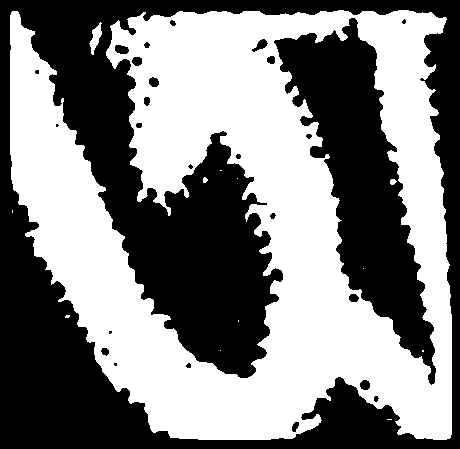

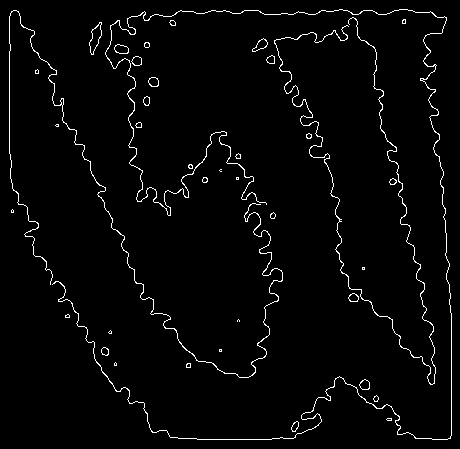

In [8]:
from google.colab.patches import cv2_imshow
cv2_imshow(img_thresh)
cv2_imshow(img_edges)

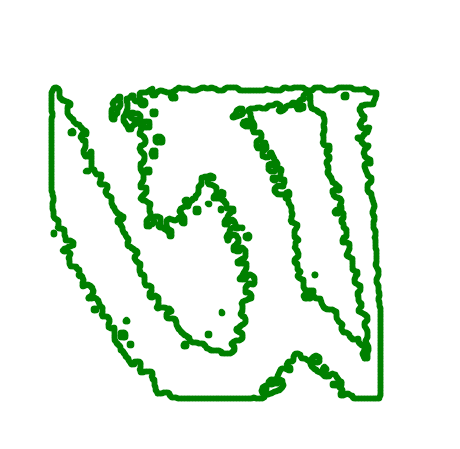

In [10]:
edges = np.loadtxt(path+'/edges.txt')
x, y = [], []
for i in range(449):
    for j in range(460):
        if edges[i,j] == 255:
            x.append(j)
            y.append(i*-1+449)

boundary_x = np.array(x)
boundary_y = np.array(y)

np.savetxt(path+'/boundary_x.txt', boundary_x)
np.savetxt(path+ '/boundary_y.txt', boundary_y)
#saveplot(path+'/images/boundary.png', boundary_x, boundary_y)
showplot(boundary_x, boundary_y)

**FILTERING OUT 'GOOD HANDWRITING' SAMPLES FROM ALL 300 SAMPLES IN DATASET FOR CHARACTER 'A'**

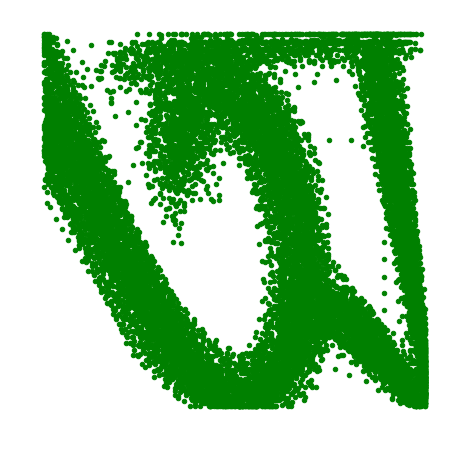

In [11]:
#RUN 4
threshold = np.loadtxt(path+'/threshold.txt')
merged_x = np.loadtxt(path+'/merged_x.txt')
merged_y = np.loadtxt(path+'/merged_y.txt')
accepted_x, accepted_y = [], []

for i in range(1,301):
    img = cv2.imread(path+f'/all_plots/{i}.png')
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)
    img_thresh = cv2.threshold(img_blur, 100, 255, cv2.THRESH_BINARY_INV)[1]
    bad = 0
    unique, counts = np.unique(img_thresh, return_counts=True)
    count_255 = dict(zip(unique, counts))

    for j in range(449):
        for k in range(460):
            if (img_thresh[j,k] == 255) and (threshold[j,k] != 255):
                bad += 1
                
    if bad < 0.1*count_255[255]:
        start = 90*(i-1)
        accepted_x.extend(merged_x[start:start+90])
        accepted_y.extend(merged_y[start:start+90])
        
np.savetxt(path+'/accepted_x.txt', accepted_x)
np.savetxt(path+'/accepted_y.txt', accepted_y)
#saveplot(path+'/images/accepted.png', accepted_x, accepted_y)
showplot(accepted_x, accepted_y)

In [ ]:
#RUN5
accepted_x = np.loadtxt(path+'/accepted_x.txt')
accepted_y = np.loadtxt(path+'/accepted_y.txt')
accepted_len = len(accepted_x)
median_x, median_y = [], []

for i in range(90):
    index = accepted_len-(90-i)+1
    median_x.append(np.median(accepted_x[i:index:90]))
    median_y.append(np.median(accepted_y[i:index:90]))

np.savetxt(path+'/median_x.txt', median_x)
np.savetxt(path+'/median_y.txt', median_y)
#saveplot(path+'/images/median.png', median_x, median_y)
showplot(median_x, median_y)

###STEPS PERFORMED IN FILTERING OUT BENCHMARK SAMPLES:<br><br>

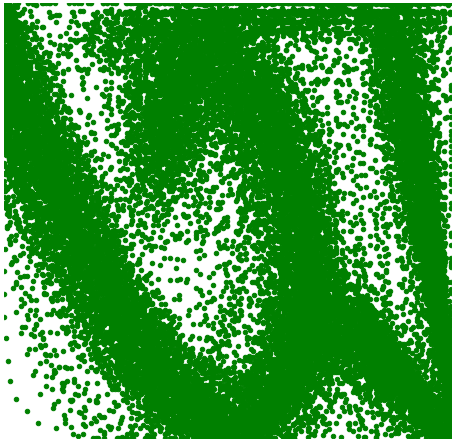
<br><br>

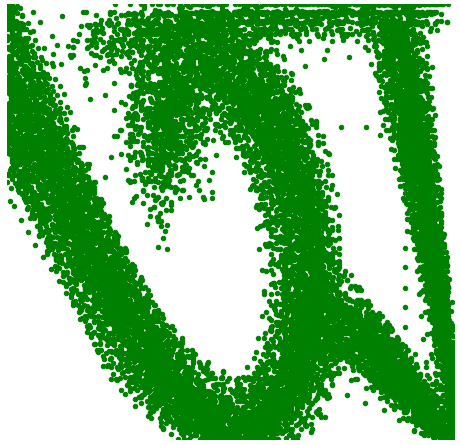
<br><br>

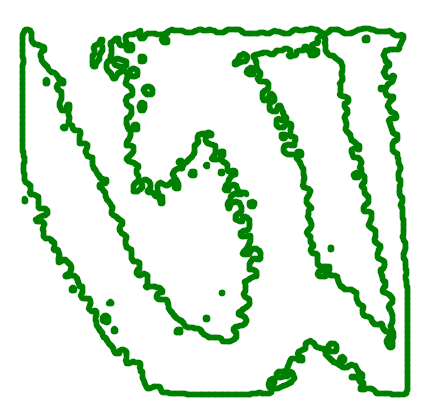
<br><br>

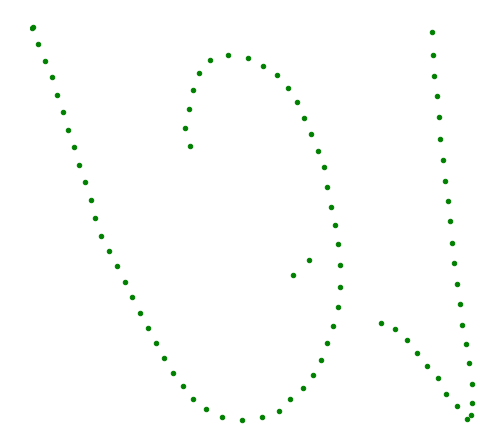